In [19]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]


章节1：原始word2vec版数据预处理+cnn,lstm.cnn_lstm训练
章节2：auto tokenizer处理上述模型


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import re, json
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize
import unicodedata
import random

Data
1. load data from csv
2. build vocabulary and word vector
3. construct dataset and dataloader


In [2]:
class NLIProcessor:
    """
    多语言文本预处理器：
    - 支持多语言 tokenization（适用于 English, French, Spanish, Russian, Chinese 等）
    - 支持 Word2Vec 训练（或加载预训练向量）
    - 自动构建词表、embedding matrix、padding/truncation
    """
    def __init__(self, embed_dim=300, min_count=2, max_len=32, seed=42):
        self.embed_dim = embed_dim
        self.min_count = min_count
        self.max_len = max_len
        self.word_index = {"<pad>": 0, "<unk>": 1}
        self.embeddings = None
        random.seed(seed)
        np.random.seed(seed)

    # -------------------------
    # 1. 文本清洗
    # -------------------------
    def clean_text(self, text):
        """统一 Unicode、去除多余空白"""
        if not isinstance(text, str):
            return ""
        # 统一 Unicode（兼容多语言）
        text = unicodedata.normalize("NFKC", text)
        # 替换换行、制表符为空格
        text = re.sub(r"[\t\n\r]+", " ", text)
        # 去除多余空格
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    # -------------------------
    # 2. 多语言 tokenization
    # -------------------------
    def tokenize(self, text):
        """
        对多语言文本进行分词：
        - 对于空格语言（英/法/西/德等），使用 NLTK wordpunct_tokenize
        - 对于中文/日文/韩文等非空格语言，按字符切分（可改成 jieba 或其他分词器）
        """
        text = self.clean_text(text)
        # 检查是否包含 CJK 字符
        if re.search(r"[\u4e00-\u9fff]", text):  # 中文
            tokens = list(text)  # 按字切分
        else:
            tokens = wordpunct_tokenize(text)  # 对空格语言更鲁棒
        return [t.lower() for t in tokens if t.strip() != ""]

    # -------------------------
    # 3. 构建词表 + Word2Vec 向量
    # -------------------------
    def build_vocab(self, texts):
        """
        输入: 一系列文本（字符串列表）
        输出: 训练好的 word2vec 模型、词表、embedding 矩阵
        """
        tokenized = [self.tokenize(t) for t in tqdm(texts, desc="Tokenizing texts")]

        print("Training Word2Vec model on multilingual corpus ...")
        self.word2vec = Word2Vec(
            tokenized,
            vector_size=self.embed_dim,
            window=5,
            min_count=self.min_count,
            workers=4,
            sg=1  # skip-gram 模式更适合多语言
        )

        # 构建词表
        for word in self.word2vec.wv.index_to_key:
            if word not in self.word_index:
                self.word_index[word] = len(self.word_index)

        # 构建 embedding matrix
        vocab_size = len(self.word_index)
        self.embeddings = np.zeros((vocab_size, self.embed_dim))
        for word, idx in self.word_index.items():
            if word in self.word2vec.wv:
                self.embeddings[idx] = self.word2vec.wv[word]
            else:
                self.embeddings[idx] = np.random.normal(scale=0.6, size=(self.embed_dim,))

        print(f"Vocab size: {vocab_size}")
        print(f"Embedding matrix shape: {self.embeddings.shape}")

    # -------------------------
    # 4. 文本编码（to IDs）
    # -------------------------
    def encode(self, text):
        """
        把文本转为固定长度的 ID 序列。
        - 未登录词用 <unk>
        - 过短补 <pad>
        - 过长截断
        """
        tokens = self.tokenize(text)
        ids = [self.word_index.get(tok, 1) for tok in tokens]  # 1 = <unk>

        # padding / truncation
        if len(ids) < self.max_len:
            ids += [0] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

class NLIDataset(Dataset):
    def __init__(self, df, processor):
        self.premises = df["premise"].tolist()
        self.hypotheses = df["hypothesis"].tolist()
        self.labels = df["label"].tolist()
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        p = self.processor.encode(self.premises[idx])
        h = self.processor.encode(self.hypotheses[idx])
        y = self.labels[idx]
        return torch.tensor(p), torch.tensor(h), torch.tensor(y)

df = pd.read_csv("./dataset/train.csv")  # Kaggle 数据集
df["label"] = df["label"].astype(int)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

# 构建词表 & 向量
processor = NLIProcessor(embed_dim=100)
processor.build_vocab(train_df["premise"].tolist() + train_df["hypothesis"].tolist())

train_dataset = NLIDataset(train_df, processor)
val_dataset = NLIDataset(val_df, processor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tokenizing texts: 100%|██████████| 19392/19392 [00:00<00:00, 30386.84it/s]


Training Word2Vec model on multilingual corpus ...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocab size: 21956
Embedding matrix shape: (21956, 100)


Train + plot

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    train_acc_list, val_acc_list = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        total, correct = 0, 0
        for a, b, y in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            a, b, y = a.to(device), b.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(a, b)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        # 验证
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for a, b, y in val_loader:
                a, b, y = a.to(device), b.to(device), y.to(device)
                out = model(a, b)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return train_acc_list, val_acc_list

def plot(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

LSTM

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[0], h[1]), dim=1)

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training LSTM ===")
model = LSTMModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM ===


Train Epoch 1:   0%|          | 0/152 [00:00<?, ?it/s]

Train Epoch 1: 100%|██████████| 152/152 [00:07<00:00, 19.46it/s]


Epoch 1: Train Acc=0.3563, Val Acc=0.3940


Train Epoch 2: 100%|██████████| 152/152 [00:09<00:00, 15.80it/s]


Epoch 2: Train Acc=0.4367, Val Acc=0.3973


Train Epoch 3: 100%|██████████| 152/152 [00:09<00:00, 15.40it/s]


Epoch 3: Train Acc=0.5642, Val Acc=0.4546


Train Epoch 4: 100%|██████████| 152/152 [00:07<00:00, 19.40it/s]


Epoch 4: Train Acc=0.7277, Val Acc=0.4394


Train Epoch 5: 100%|██████████| 152/152 [00:09<00:00, 15.56it/s]


Epoch 5: Train Acc=0.8471, Val Acc=0.4130


Train Epoch 6: 100%|██████████| 152/152 [00:09<00:00, 15.89it/s]


Epoch 6: Train Acc=0.9127, Val Acc=0.4031


Train Epoch 7: 100%|██████████| 152/152 [00:07<00:00, 19.63it/s]


Epoch 7: Train Acc=0.9408, Val Acc=0.4080


Train Epoch 8: 100%|██████████| 152/152 [00:09<00:00, 15.88it/s]


Epoch 8: Train Acc=0.9633, Val Acc=0.3985


Train Epoch 9: 100%|██████████| 152/152 [00:09<00:00, 15.75it/s]


Epoch 9: Train Acc=0.9746, Val Acc=0.4031


Train Epoch 10: 100%|██████████| 152/152 [00:07<00:00, 19.43it/s]


Epoch 10: Train Acc=0.9816, Val Acc=0.4014


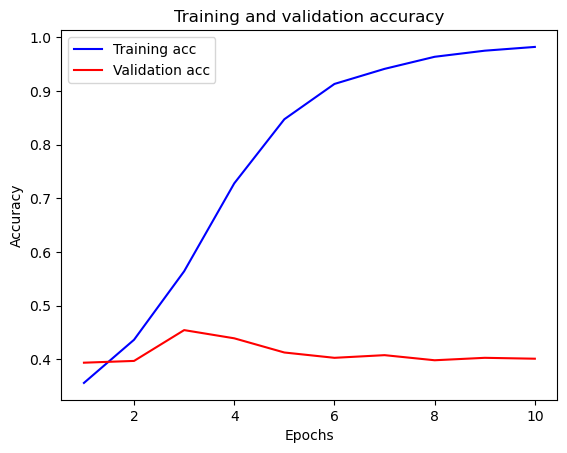

In [25]:
plot(train_acc, val_acc)

In [ ]:
CNN

In [26]:
class CNNModel(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128 * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN ===")
model = CNNModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN ===


Train Epoch 1: 100%|██████████| 152/152 [00:03<00:00, 50.46it/s]


Epoch 1: Train Acc=0.3728, Val Acc=0.3804


Train Epoch 2: 100%|██████████| 152/152 [00:00<00:00, 178.63it/s]


Epoch 2: Train Acc=0.4530, Val Acc=0.4171


Train Epoch 3: 100%|██████████| 152/152 [00:02<00:00, 55.54it/s]


Epoch 3: Train Acc=0.5380, Val Acc=0.4323


Train Epoch 4: 100%|██████████| 152/152 [00:02<00:00, 55.47it/s]


Epoch 4: Train Acc=0.6468, Val Acc=0.4422


Train Epoch 5: 100%|██████████| 152/152 [00:02<00:00, 54.43it/s]


Epoch 5: Train Acc=0.8100, Val Acc=0.4290


Train Epoch 6: 100%|██████████| 152/152 [00:02<00:00, 54.66it/s]


Epoch 6: Train Acc=0.9195, Val Acc=0.4344


Train Epoch 7: 100%|██████████| 152/152 [00:02<00:00, 54.49it/s]


Epoch 7: Train Acc=0.9712, Val Acc=0.4237


Train Epoch 8: 100%|██████████| 152/152 [00:02<00:00, 54.14it/s]


Epoch 8: Train Acc=0.9881, Val Acc=0.4257


Train Epoch 9: 100%|██████████| 152/152 [00:02<00:00, 51.44it/s]


Epoch 9: Train Acc=0.9939, Val Acc=0.4196


Train Epoch 10: 100%|██████████| 152/152 [00:02<00:00, 54.30it/s]


Epoch 10: Train Acc=0.9967, Val Acc=0.4175


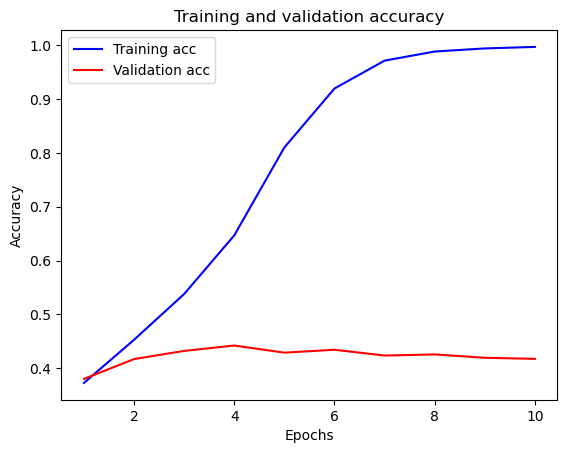

In [27]:
plot(train_acc, val_acc)

CNN+LSTM

In [ ]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, hidden, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x)).permute(0, 2, 1)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[0], h[1]), dim=1)

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN+LSTM ===")
model = CNN_LSTM_Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN+LSTM ===


Train Epoch 1: 100%|██████████| 152/152 [00:09<00:00, 16.86it/s]


Epoch 1: Train Acc=0.3506, Val Acc=0.4051


Train Epoch 2: 100%|██████████| 152/152 [00:10<00:00, 14.03it/s]


Epoch 2: Train Acc=0.4292, Val Acc=0.4286


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 13.95it/s]


Epoch 3: Train Acc=0.5563, Val Acc=0.4427


Train Epoch 4: 100%|██████████| 152/152 [00:08<00:00, 17.59it/s]


Epoch 4: Train Acc=0.7007, Val Acc=0.4241


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 14.14it/s]


Epoch 5: Train Acc=0.8133, Val Acc=0.4183


Train Epoch 6: 100%|██████████| 152/152 [00:10<00:00, 14.17it/s]


Epoch 6: Train Acc=0.8796, Val Acc=0.4026


Train Epoch 7: 100%|██████████| 152/152 [00:08<00:00, 17.66it/s]


Epoch 7: Train Acc=0.9179, Val Acc=0.3952


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 14.13it/s]


Epoch 8: Train Acc=0.9422, Val Acc=0.3911


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 14.16it/s]


Epoch 9: Train Acc=0.9562, Val Acc=0.3903


Train Epoch 10: 100%|██████████| 152/152 [00:08<00:00, 17.53it/s]


Epoch 10: Train Acc=0.9646, Val Acc=0.3696


In [4]:
plot(train_acc, val_acc)

NameError: name 'train_acc' is not defined

LSTM CNN

In [10]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        # embedding 层
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        # LSTM 层
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        # CNN 层作用于 LSTM 输出
        self.conv = nn.Conv1d(hidden * 2, 128, kernel_size=3, padding=1)
        # 池化层
        self.pool = nn.AdaptiveMaxPool1d(1)
        # 分类器
        self.fc = nn.Linear(128 * 4, num_classes)  # *4 拼接句子对特征

    def encode(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)          # (batch, seq_len, embed_dim)
        lstm_out, _ = self.lstm(x)    # (batch, seq_len, hidden*2)
        x = lstm_out.permute(0, 2, 1) # (batch, hidden*2, seq_len) 适应 Conv1d
        x = torch.relu(self.conv(x))  # (batch, 128, seq_len)
        x = self.pool(x).squeeze(2)   # (batch, 128)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training LSTM+CNN ===")
model = LSTM_CNN_Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM+CNN ===


Train Epoch 1: 100%|██████████| 152/152 [00:08<00:00, 17.15it/s]


Epoch 1: Train Acc=0.3721, Val Acc=0.3890


Train Epoch 2: 100%|██████████| 152/152 [00:11<00:00, 13.68it/s]


Epoch 2: Train Acc=0.4451, Val Acc=0.4596


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 14.04it/s]


Epoch 3: Train Acc=0.5774, Val Acc=0.4592


Train Epoch 4: 100%|██████████| 152/152 [00:10<00:00, 14.23it/s]


Epoch 4: Train Acc=0.7569, Val Acc=0.4460


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 13.94it/s]


Epoch 5: Train Acc=0.8772, Val Acc=0.4196


Train Epoch 6: 100%|██████████| 152/152 [00:08<00:00, 18.74it/s]


Epoch 6: Train Acc=0.9303, Val Acc=0.4278


Train Epoch 7: 100%|██████████| 152/152 [00:10<00:00, 14.29it/s]


Epoch 7: Train Acc=0.9619, Val Acc=0.4179


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 13.93it/s]


Epoch 8: Train Acc=0.9760, Val Acc=0.4130


Train Epoch 9: 100%|██████████| 152/152 [00:08<00:00, 18.79it/s]


Epoch 9: Train Acc=0.9850, Val Acc=0.4163


Train Epoch 10: 100%|██████████| 152/152 [00:10<00:00, 14.05it/s]


Epoch 10: Train Acc=0.9882, Val Acc=0.4171


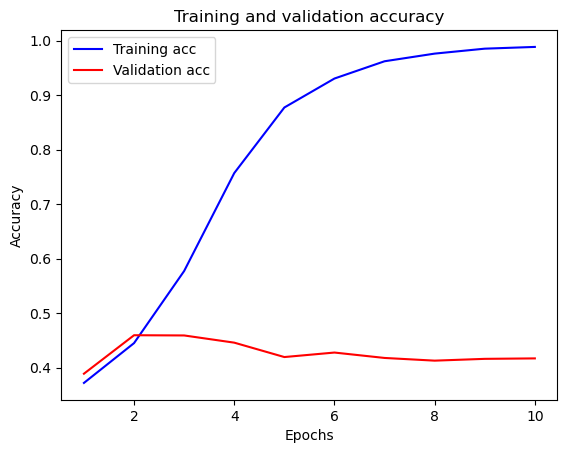

[0.3721122112211221, 0.4451320132013201, 0.5773514851485149, 0.7569100660066007, 0.8771658415841584, 0.9302805280528053, 0.9619430693069307, 0.9759694719471947, 0.9850453795379538, 0.9882425742574258] [0.389026402640264, 0.45957095709570955, 0.4591584158415842, 0.445957095709571, 0.41955445544554454, 0.4278052805280528, 0.4179042904290429, 0.41295379537953797, 0.41625412541254125, 0.41707920792079206]


In [11]:
plot(train_acc, val_acc)
print(train_acc, val_acc)

Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_heads=4, num_layers=2, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(1, 0, 2)  # (seq, batch, dim)
        x = self.transformer(x).permute(1, 2, 0)
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training Transformer ===")

model = TransformerModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


/home/amamiya/anaconda3/envs/deepml/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



=== Training Transformer ===


Train Epoch 1:   0%|          | 0/152 [00:00<?, ?it/s]

Train Epoch 1: 100%|██████████| 152/152 [00:07<00:00, 19.55it/s]


Epoch 1: Train Acc=0.3630, Val Acc=0.3919


Train Epoch 2: 100%|██████████| 152/152 [00:10<00:00, 14.91it/s]


Epoch 2: Train Acc=0.3929, Val Acc=0.3956


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 14.74it/s]


Epoch 3: Train Acc=0.4480, Val Acc=0.4286


Train Epoch 4: 100%|██████████| 152/152 [00:07<00:00, 20.30it/s]


Epoch 4: Train Acc=0.6675, Val Acc=0.3989


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 14.88it/s]


Epoch 5: Train Acc=0.8504, Val Acc=0.3857


Train Epoch 6: 100%|██████████| 152/152 [00:10<00:00, 14.91it/s]


Epoch 6: Train Acc=0.9154, Val Acc=0.3684


Train Epoch 7: 100%|██████████| 152/152 [00:07<00:00, 19.68it/s]


Epoch 7: Train Acc=0.9483, Val Acc=0.3667


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 15.06it/s]


Epoch 8: Train Acc=0.9643, Val Acc=0.3655


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 14.96it/s]


Epoch 9: Train Acc=0.9694, Val Acc=0.3738


Train Epoch 10: 100%|██████████| 152/152 [00:07<00:00, 20.39it/s]


Epoch 10: Train Acc=0.9814, Val Acc=0.3767


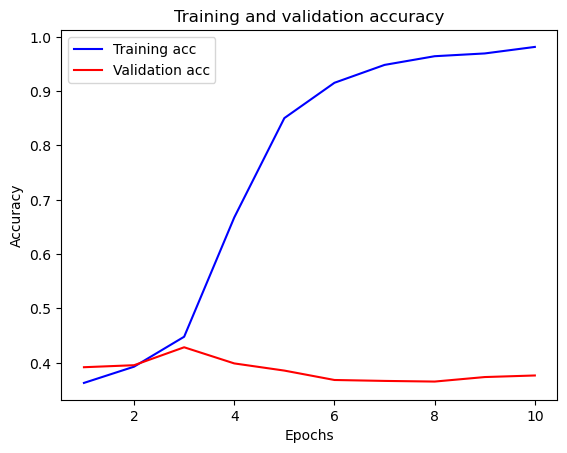

In [16]:
transformer_train_acc = [0.3630, 0.3929, 0.4480, 0.6675, 0.8504, 0.9154, 0.9483, 0.9643, 0.9694, 0.9814]
transformer_val_acc   = [0.3919, 0.3956, 0.4286, 0.3989, 0.3857, 0.3684, 0.3667, 0.3655, 0.3738, 0.3767]
plot(transformer_train_acc, transformer_val_acc)

word2vec cnn, lstm, cnn+lstm横项对比:
都一样烂，cnn还强点

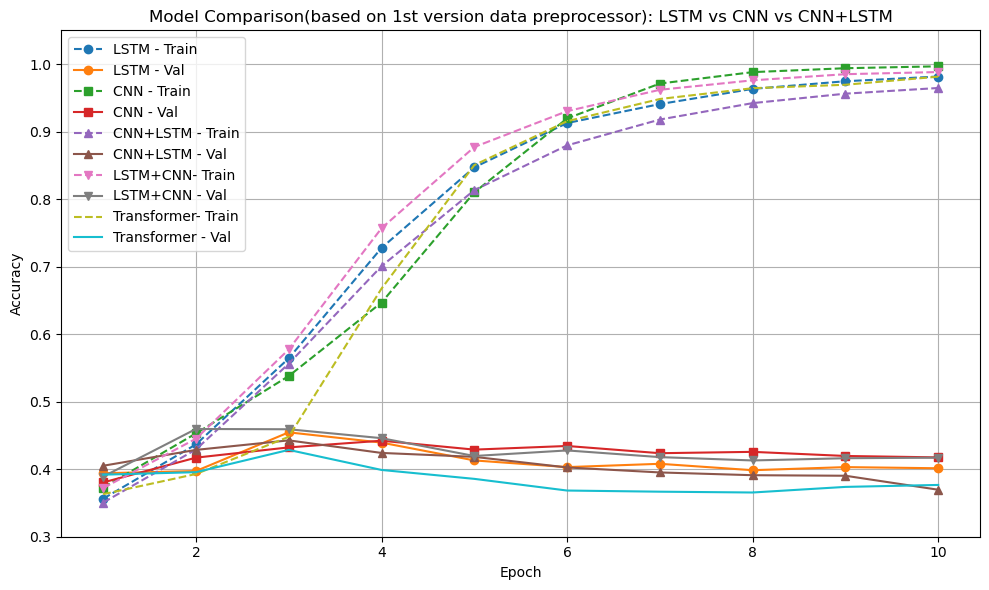

In [ ]:
lstm_train_acc = [0.3563, 0.4367, 0.5642, 0.7277, 0.8471, 0.9127, 0.9408, 0.9633, 0.9746, 0.9816]
lstm_val_acc   = [0.3940, 0.3973, 0.4546, 0.4394, 0.4130, 0.4031, 0.4080, 0.3985, 0.4031, 0.4014]

cnn_train_acc = [0.3728, 0.4530, 0.5380, 0.6468, 0.8100, 0.9195, 0.9712, 0.9881, 0.9939, 0.9967]
cnn_val_acc   = [0.3804, 0.4171, 0.4323, 0.4422, 0.4290, 0.4344, 0.4237, 0.4257, 0.4196, 0.4175]

cnn_lstm_train_acc = [0.3506, 0.4292, 0.5563, 0.7007, 0.8133, 0.8796, 0.9179, 0.9422, 0.9562, 0.9646]
cnn_lstm_val_acc   = [0.4051, 0.4286, 0.4427, 0.4241, 0.4183, 0.4026, 0.3952, 0.3911, 0.3903, 0.3696]

lstm_cnn_train_acc = [0.3721122112211221, 0.4451320132013201, 0.5773514851485149, 0.7569100660066007, 0.8771658415841584, 0.9302805280528053, 0.9619430693069307, 0.9759694719471947, 0.9850453795379538, 0.9882425742574258]
lstm_cnn_val_acc =  [0.389026402640264, 0.45957095709570955, 0.4591584158415842, 0.445957095709571, 0.41955445544554454, 0.4278052805280528, 0.4179042904290429, 0.41295379537953797, 0.41625412541254125, 0.41707920792079206]

transformer_train_acc = [0.3630, 0.3929, 0.4480, 0.6675, 0.8504, 0.9154, 0.9483, 0.9643, 0.9694, 0.9814]
transformer_val_acc   = [0.3919, 0.3956, 0.4286, 0.3989, 0.3857, 0.3684, 0.3667, 0.3655, 0.3738, 0.3767]


# 横轴
epochs = list(range(1, 11))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(epochs, lstm_train_acc, label='LSTM - Train', marker='o', linestyle='--')
plt.plot(epochs, lstm_val_acc, label='LSTM - Val', marker='o', linestyle='-')

plt.plot(epochs, cnn_train_acc, label='CNN - Train', marker='s', linestyle='--')
plt.plot(epochs, cnn_val_acc, label='CNN - Val', marker='s', linestyle='-')

plt.plot(epochs, cnn_lstm_train_acc, label='CNN+LSTM - Train', marker='^', linestyle='--')
plt.plot(epochs, cnn_lstm_val_acc, label='CNN+LSTM - Val', marker='^', linestyle='-')

plt.plot(epochs, lstm_cnn_train_acc, label='LSTM+CNN- Train', marker='v', linestyle='--')
plt.plot(epochs, lstm_cnn_val_acc, label='LSTM+CNN - Val', marker='v', linestyle='-')

plt.plot(epochs, transformer_train_acc, label='Transformer- Train', marker=',', linestyle='--')
plt.plot(epochs, transformer_val_acc, label='Transformer - Val', marker=',', linestyle='-')

# 图形美化
plt.title('Model Comparison: LSTM vs CNN vs CNN+LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()

transfer learning
running on kaggle GPU

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# -----------------------------
# 数据准备
# -----------------------------
class NLIDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row['premise'],
            row['hypothesis'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        if 'label' in row:
            item['labels'] = torch.tensor(row['label'])
        return item

# -----------------------------
# 配置模型
# -----------------------------
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")
model = AutoModelForSequenceClassification.from_pretrained("MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7", num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -----------------------------
# 载入数据
# -----------------------------
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 可选：划分训练集和验证集
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = NLIDataset(train_data, tokenizer)
val_dataset = NLIDataset(val_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 训练函数
# -----------------------------
optimizer = AdamW(model.parameters(), lr=2e-5)

def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# -----------------------------
# 训练循环
# -----------------------------
EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train_one_epoch()
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")

# -----------------------------
# 测试集推理
# -----------------------------
test_dataset = NLIDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

test_df['label'] = all_preds
test_df[['id', 'label']].to_csv('submission.csv', index=False)
print("Submission saved!")

joeddav/xlm-roberta-large-xnli
cuda outof memo! batch size 16
print every 10 batches

In [ ]:
model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.config.hidden_dropout_prob = 0.2
model.to(torch.device(device))

In [ ]:
        # 计算训练准确率
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)


        # 每 10 batch 打印一次训练状态
        if step % 10 == 0 or step == len(train_loader):
            avg_loss = total_loss / step
            acc = correct / total
            print(f"Step {step}/{len(train_loader)} - Avg Loss: {avg_loss:.4f} - Acc: {acc:.4f}")